In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm, tqdm_notebook

import sklearn
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

C:\Users\82104\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\82104\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\82104\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\82104\Anaconda3\lib\site-packages\skl

In [2]:
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.21.0
pandas 1.3.0
sklearn 0.21.2
lightgbm 3.2.1


In [3]:
sales = pd.read_csv('Dataset/sales_train.csv')
shops = pd.read_csv('Dataset/shops.csv')
items = pd.read_csv('Dataset/items.csv')
items_categories = pd.read_csv('Dataset/item_categories.csv')
sample_submission = pd.read_csv('Dataset/sample_submission.csv')
test_data = pd.read_csv('Dataset/test.csv')

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
items_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## Exploratory Data Analysisb

#### (1) Items

In [9]:
items_per_category = items.item_category_id.value_counts().iloc[:10]
items_per_category = items_per_category.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'Number of items per category')

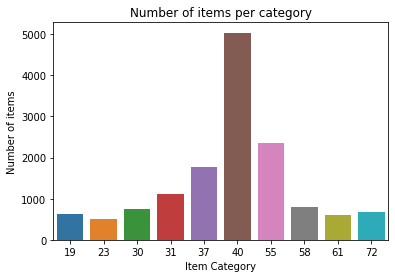

In [10]:
sns.barplot(items_per_category.index, items_per_category.values)
plt.xlabel("Item Category")
plt.ylabel("Number of items")
plt.title("Number of items per category")

#### (2) Popular shops based on item count

In [11]:
popular_shops = sales.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Popular shops')

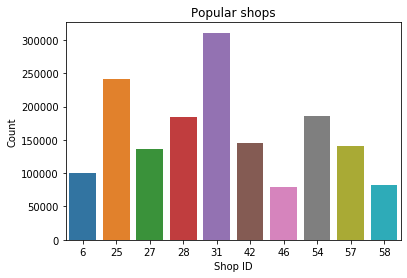

In [12]:
sns.barplot(popular_shops.index, popular_shops.values)
plt.xlabel("Shop ID")
plt.ylabel("Count")
plt.title("Popular shops")

In [13]:
popular_items = sales.groupby('item_id')['item_cnt_day'].sum()
popular_items = popular_items.sort_values(ascending=False)[:10]

Text(0.5, 1.0, 'Popular items')

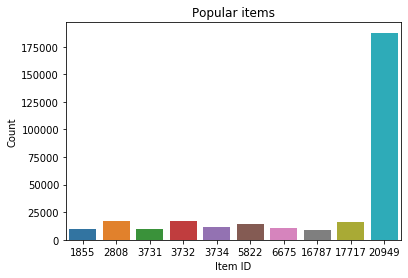

In [14]:
sns.barplot(popular_items.index, popular_items.values)
plt.xlabel("Item ID")
plt.ylabel("Count")
plt.title("Popular items")

#### (3) Items sold in each month

In [15]:
item_cnt_month = sales.groupby('date_block_num')['item_cnt_day'].sum()

C:\Users\82104\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\82104\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0.5, 1.0, 'Number of items sold in each month')

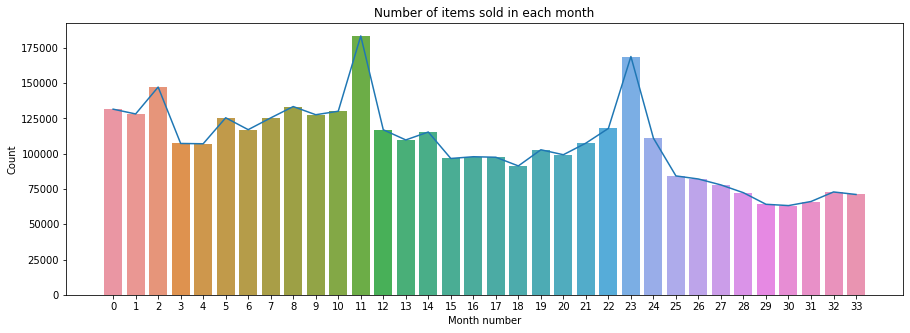

In [16]:
plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Number of items sold in each month")

#### (4) Total price of items sold in each month

In [17]:
price_cnt_month = sales.groupby('date_block_num')['item_price'].sum()

Text(0.5, 1.0, 'Total price of items sold in each month')

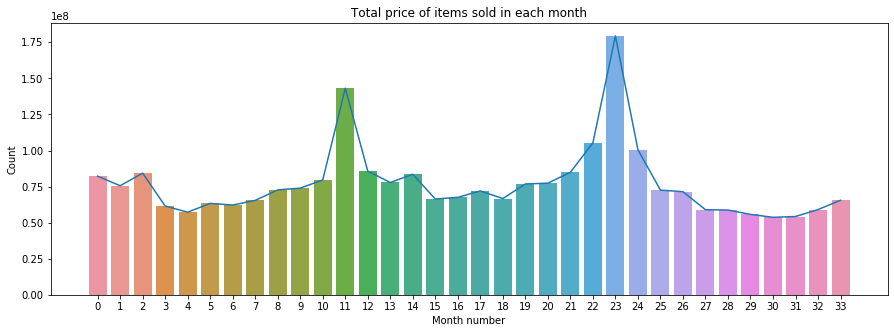

In [18]:
plt.figure(figsize=(15,5))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

#### (5) Corr between Number of items sold & Total price of all items

In [19]:
np.corrcoef(item_cnt_month.values, price_cnt_month.values)

array([[1.        , 0.73469191],
       [0.73469191, 1.        ]])

## Preprocessing and Feature Engineering

In [20]:
test_block = sales['date_block_num'].max() + 1
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [21]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test_data])

In [22]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [23]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


del [[grid, gb]]

In [24]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [25]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

In [26]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')

In [28]:
to_drop_cols

['target_item', 'target', 'target_shop', 'date_block_num']

In [29]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [30]:
dates = all_data['date_block_num']

In [31]:
dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

In [32]:
X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

In [33]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,...,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [34]:
y_train

array([ 4.,  3., 14., ...,  0.,  0.,  0.])

## Modeling ( Linear Regression, LightGBM, Catboost)

#### (1) Linear Regression

In [36]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

In [38]:
submission_lr = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lr})
submission_lr.head()

,ID,item_cnt_month
0,0,0.595136
1,1,0.101658
2,2,0.955156
3,3,0.234573
4,4,0.118508


#### (2) LightGBM

In [40]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.756074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [41]:
submission_lgb = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission_lgb.head()

,ID,item_cnt_month
0,0,0.467167
1,1,0.172439
2,2,0.832535
3,3,0.317599
4,4,1.890841


In [42]:
submission_final = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': (pred_lgb+pred_lr)/2})
submission_final.head()

,ID,item_cnt_month
0,0,0.531152
1,1,0.137049
2,2,0.893846
3,3,0.276086
4,4,1.004674


## Validation

In [43]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

In [45]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb

27
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.531871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
28
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.560974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
29
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.747502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
30
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.622905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
31
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

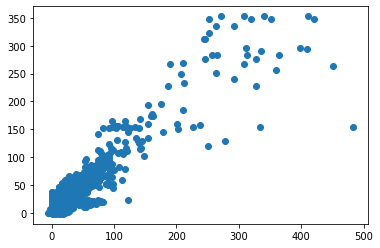

In [46]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

## Ensemble - Stacking

In [47]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
pred_stacking = lr.predict(X_train_level2)

In [50]:
pred_stacking

array([0.80388367, 2.66149903, 0.47633409, ..., 0.19438954, 0.04936662,
       0.01772888])

## Submission

In [51]:
submission_final.to_csv('submission_final.csv', index=False)